logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for British Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messa

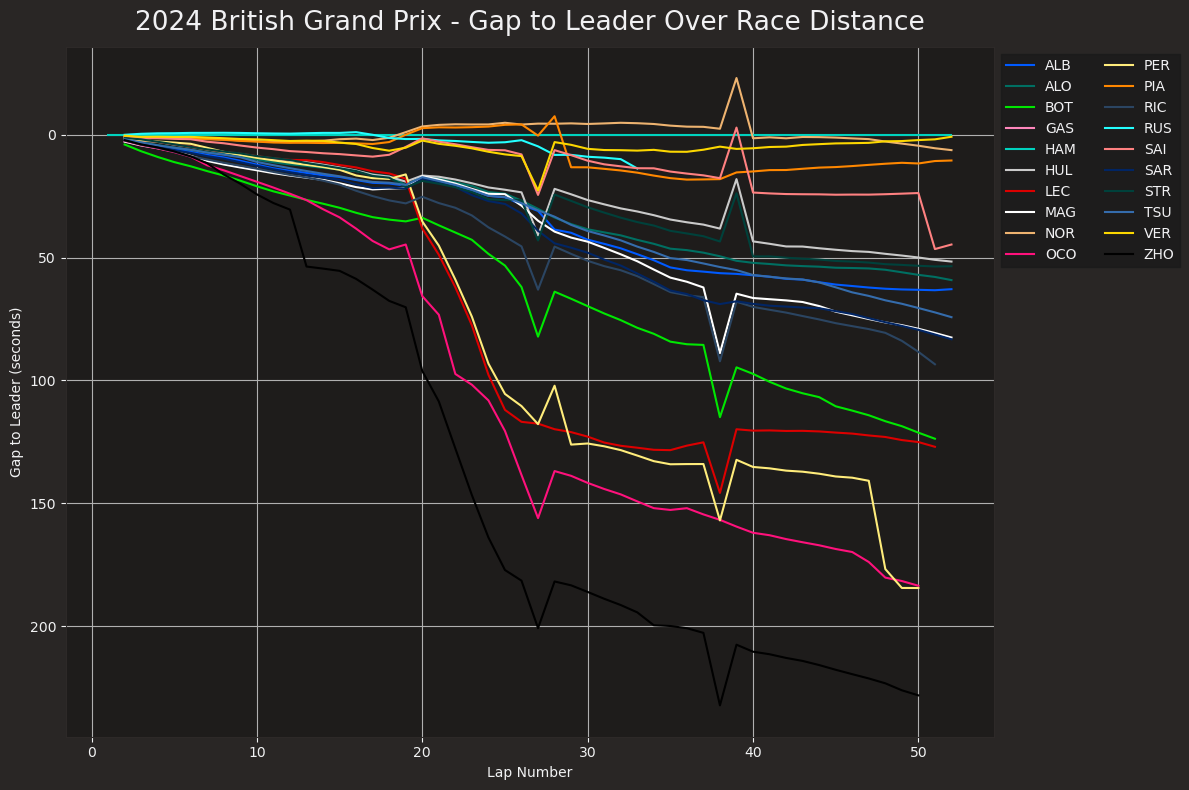

In [28]:
import fastf1 as ff1
import matplotlib.pyplot as plt
import pandas as pd

# Set plotting theme
ff1.plotting.setup_mpl()

# Load session (Example: 2024 British GP Race)
session = ff1.get_session(2024, 'British', 'R')
session.load()

# Create a mapping of driver abbreviations to full names
drivers_info = session.results[['Abbreviation', 'FullName']].set_index('Abbreviation')['FullName'].to_dict()

# Get laps data for all drivers
laps = session.laps

# Find the leader's lap times and calculate cumulative race time
leader_abbr = session.results.iloc[0]['Abbreviation']
leader_laps = laps.pick_driver(leader_abbr).copy()
leader_laps['CumulativeTime'] = leader_laps['LapTime'].cumsum()

# Create a list to store each driver's gap to the leader data
gap_list = []

for driver in laps['Driver'].unique():
    if driver == leader_abbr:
        leader_laps['GapToLeader'] = 0  # Leader has zero gap
        gap_list.append(leader_laps[['LapNumber', 'Driver', 'GapToLeader']])
    else:
        driver_laps = laps.pick_driver(driver).copy()
        driver_laps['CumulativeTime'] = driver_laps['LapTime'].cumsum()

        # Merge with leader's cumulative times based on LapNumber
        merged_laps = pd.merge(driver_laps, leader_laps[['LapNumber', 'CumulativeTime']], on='LapNumber', how='left', suffixes=('', '_Leader'))

        # Calculate gap to leader
        merged_laps['GapToLeader'] = (merged_laps['CumulativeTime'] - merged_laps['CumulativeTime_Leader']).dt.total_seconds()

        # Append driver's gap data
        gap_list.append(merged_laps[['LapNumber', 'Driver', 'GapToLeader']])

# Concatenate the list of DataFrames into a single DataFrame
gap_df = pd.concat(gap_list).sort_values(by=['LapNumber', 'Driver'])

# Get driver colors from fastf1.plotting
driver_colors = ff1.plotting.DRIVER_COLORS

# Plot the gap to leader chart
plt.figure(figsize=(12, 8))

for driver in gap_df['Driver'].unique():
    driver_full_name = drivers_info.get(driver, 'Unknown').lower()  # Convert name to lowercase to match dictionary keys
    color = driver_colors.get(driver_full_name, '#000000')  # Fallback to black if driver not found
    driver_gap = gap_df[gap_df['Driver'] == driver]
    plt.plot(driver_gap['LapNumber'], driver_gap['GapToLeader'], label=driver, color=color)

plt.xlabel('Lap Number')
plt.ylabel('Gap to Leader (seconds)')
plt.title('2024 British Grand Prix - Gap to Leader Over Race Distance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)  # Place legend outside the plot
plt.grid(True)
plt.gca().invert_yaxis()  # Invert y-axis to have the leader on top
plt.tight_layout()
plt.show()

core           INFO 	Loading data for British Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2'

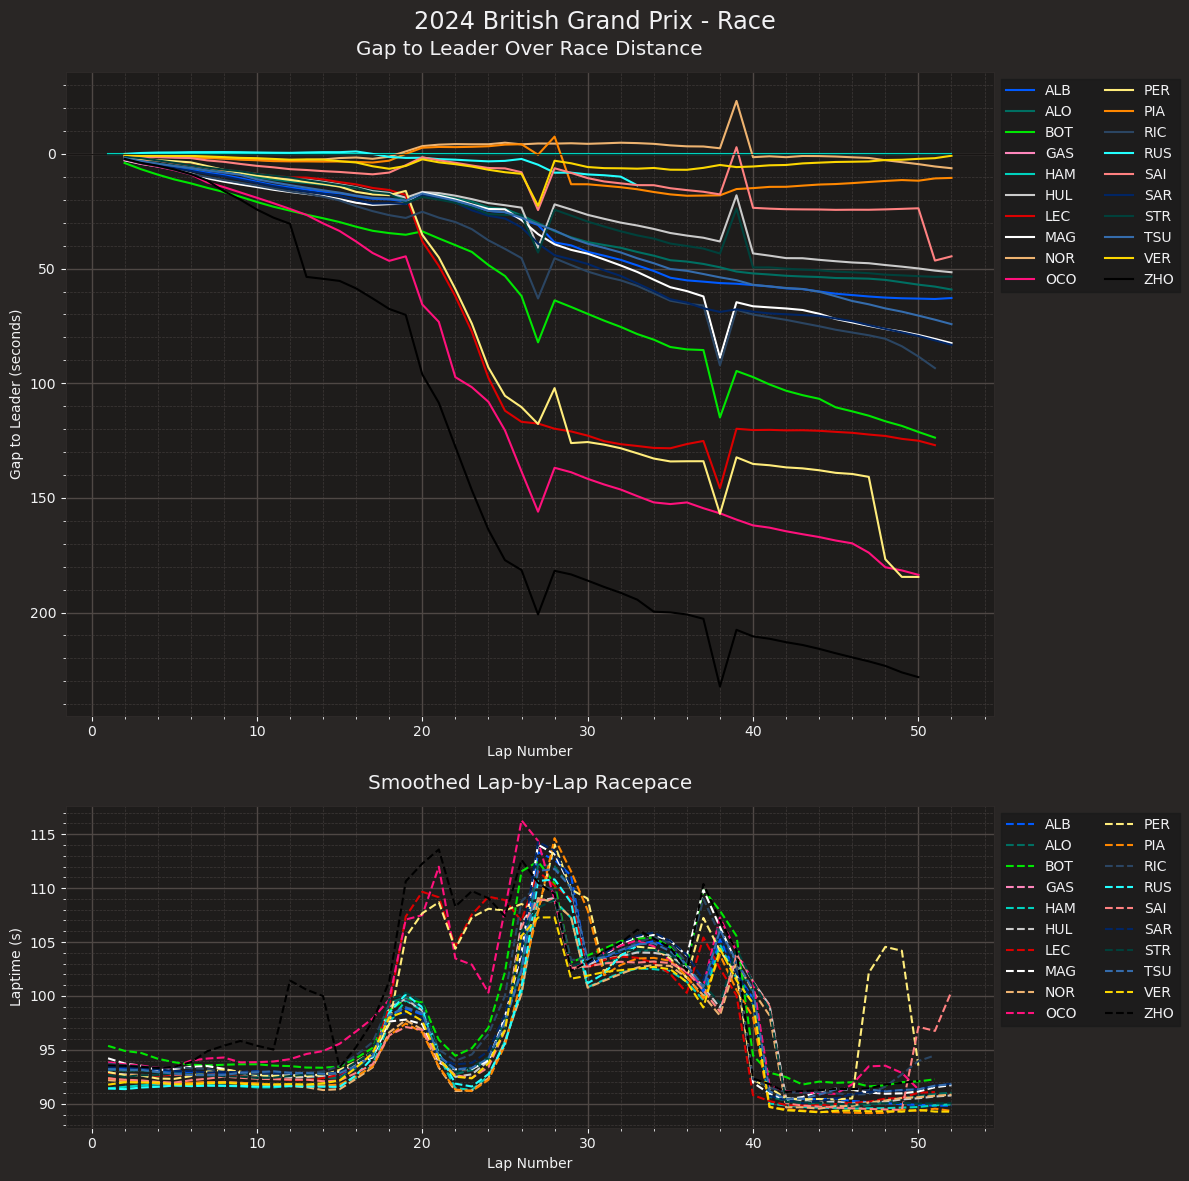

In [50]:
import fastf1 as ff1
from fastf1 import plotting
import matplotlib.pyplot as plt
import pandas as pd

# Set plotting theme
plotting.setup_mpl()

# Load session (Example: 2024 British GP Race)
session = ff1.get_session(2024, 'British', 'R')
session.load()

# Create a mapping of driver abbreviations to full names
drivers_info = session.results[['Abbreviation', 'FullName']].set_index('Abbreviation')['FullName'].to_dict()

# Get laps data for all drivers
laps = session.laps

# Find the leader's lap times and calculate cumulative race time
leader_abbr = session.results.iloc[0]['Abbreviation']
leader_laps = laps.pick_driver(leader_abbr).copy()
leader_laps['CumulativeTime'] = leader_laps['LapTime'].cumsum()

# Create a list to store each driver's gap to the leader data
gap_list = []
lap_times_list = []

for driver in laps['Driver'].unique():
    driver_laps = laps.pick_driver(driver).copy()
    driver_laps['CumulativeTime'] = driver_laps['LapTime'].cumsum()

    # Append lap times for smoothing plot
    lap_times_list.append(driver_laps[['LapNumber', 'LapTime', 'Driver']])

    if driver == leader_abbr:
        # Leader has zero gap
        driver_laps['GapToLeader'] = 0
        gap_list.append(driver_laps[['LapNumber', 'Driver', 'GapToLeader']])
    else:
        # Merge with leader's cumulative times based on LapNumber
        merged_laps = pd.merge(driver_laps, leader_laps[['LapNumber', 'CumulativeTime']], on='LapNumber', how='left', suffixes=('', '_Leader'))

        # Calculate gap to leader
        merged_laps['GapToLeader'] = (merged_laps['CumulativeTime'] - merged_laps['CumulativeTime_Leader']).dt.total_seconds()

        # Append driver's gap data
        gap_list.append(merged_laps[['LapNumber', 'Driver', 'GapToLeader']])

# Concatenate the list of DataFrames into single DataFrames
gap_df = pd.concat(gap_list).sort_values(by=['LapNumber', 'Driver'])
lap_times_df = pd.concat(lap_times_list).sort_values(by=['LapNumber', 'Driver'])

# Plot configuration
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 0.5]})

# DRIVER_COLORS
driver_colors = plotting.DRIVER_COLORS

# Plot gap to leader chart
for driver in gap_df['Driver'].unique():
    driver_full_name = drivers_info.get(driver, 'Unknown').lower()  # Convert name to lowercase to match dictionary keys
    color = driver_colors.get(driver_full_name, '#000000')  # Fallback to black if driver not found
    driver_gap = gap_df[gap_df['Driver'] == driver]
    ax1.plot(driver_gap['LapNumber'], driver_gap['GapToLeader'], label=driver, color=color)

ax1.set_xlabel('Lap Number')
ax1.set_ylabel('Gap to Leader (seconds)')
ax1.set_title('Gap to Leader Over Race Distance', size='x-large')
ax1.axhline(y=0, color='black', linewidth=0.5)  # Add horizontal line at y=0
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)  # Place legend outside the plot
ax1.grid(True)
ax1.invert_yaxis()  # Invert y-axis to have the leader on top

# Plot smoothed lap-by-lap race pace
for driver in lap_times_df['Driver'].unique():
    driver_full_name = drivers_info.get(driver, 'Unknown').lower()  # Convert name to lowercase to match dictionary keys
    color = driver_colors.get(driver_full_name, '#000000')  # Fallback to black if driver not found
    driver_lap_times = lap_times_df[lap_times_df['Driver'] == driver]

    # Convert LapTime to total seconds for smoothing
    lap_times_seconds = driver_lap_times['LapTime'].dt.total_seconds()

    # Smooth lap times (rolling average)
    smoothed_times = lap_times_seconds.rolling(window=3, min_periods=1, center=True).mean()

    ax2.plot(driver_lap_times['LapNumber'], smoothed_times, label=driver, color=color, linestyle='--')

ax2.set_xlabel('Lap Number')
ax2.set_ylabel('Laptime (s)')
ax2.set_title('Smoothed Lap-by-Lap Racepace', size='x-large')
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)  # Place legend outside the plot
ax2.grid(True)

plt.suptitle('2024 British Grand Prix - Race', size='xx-large')

plt.tight_layout()
plt.show()

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for British Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messa

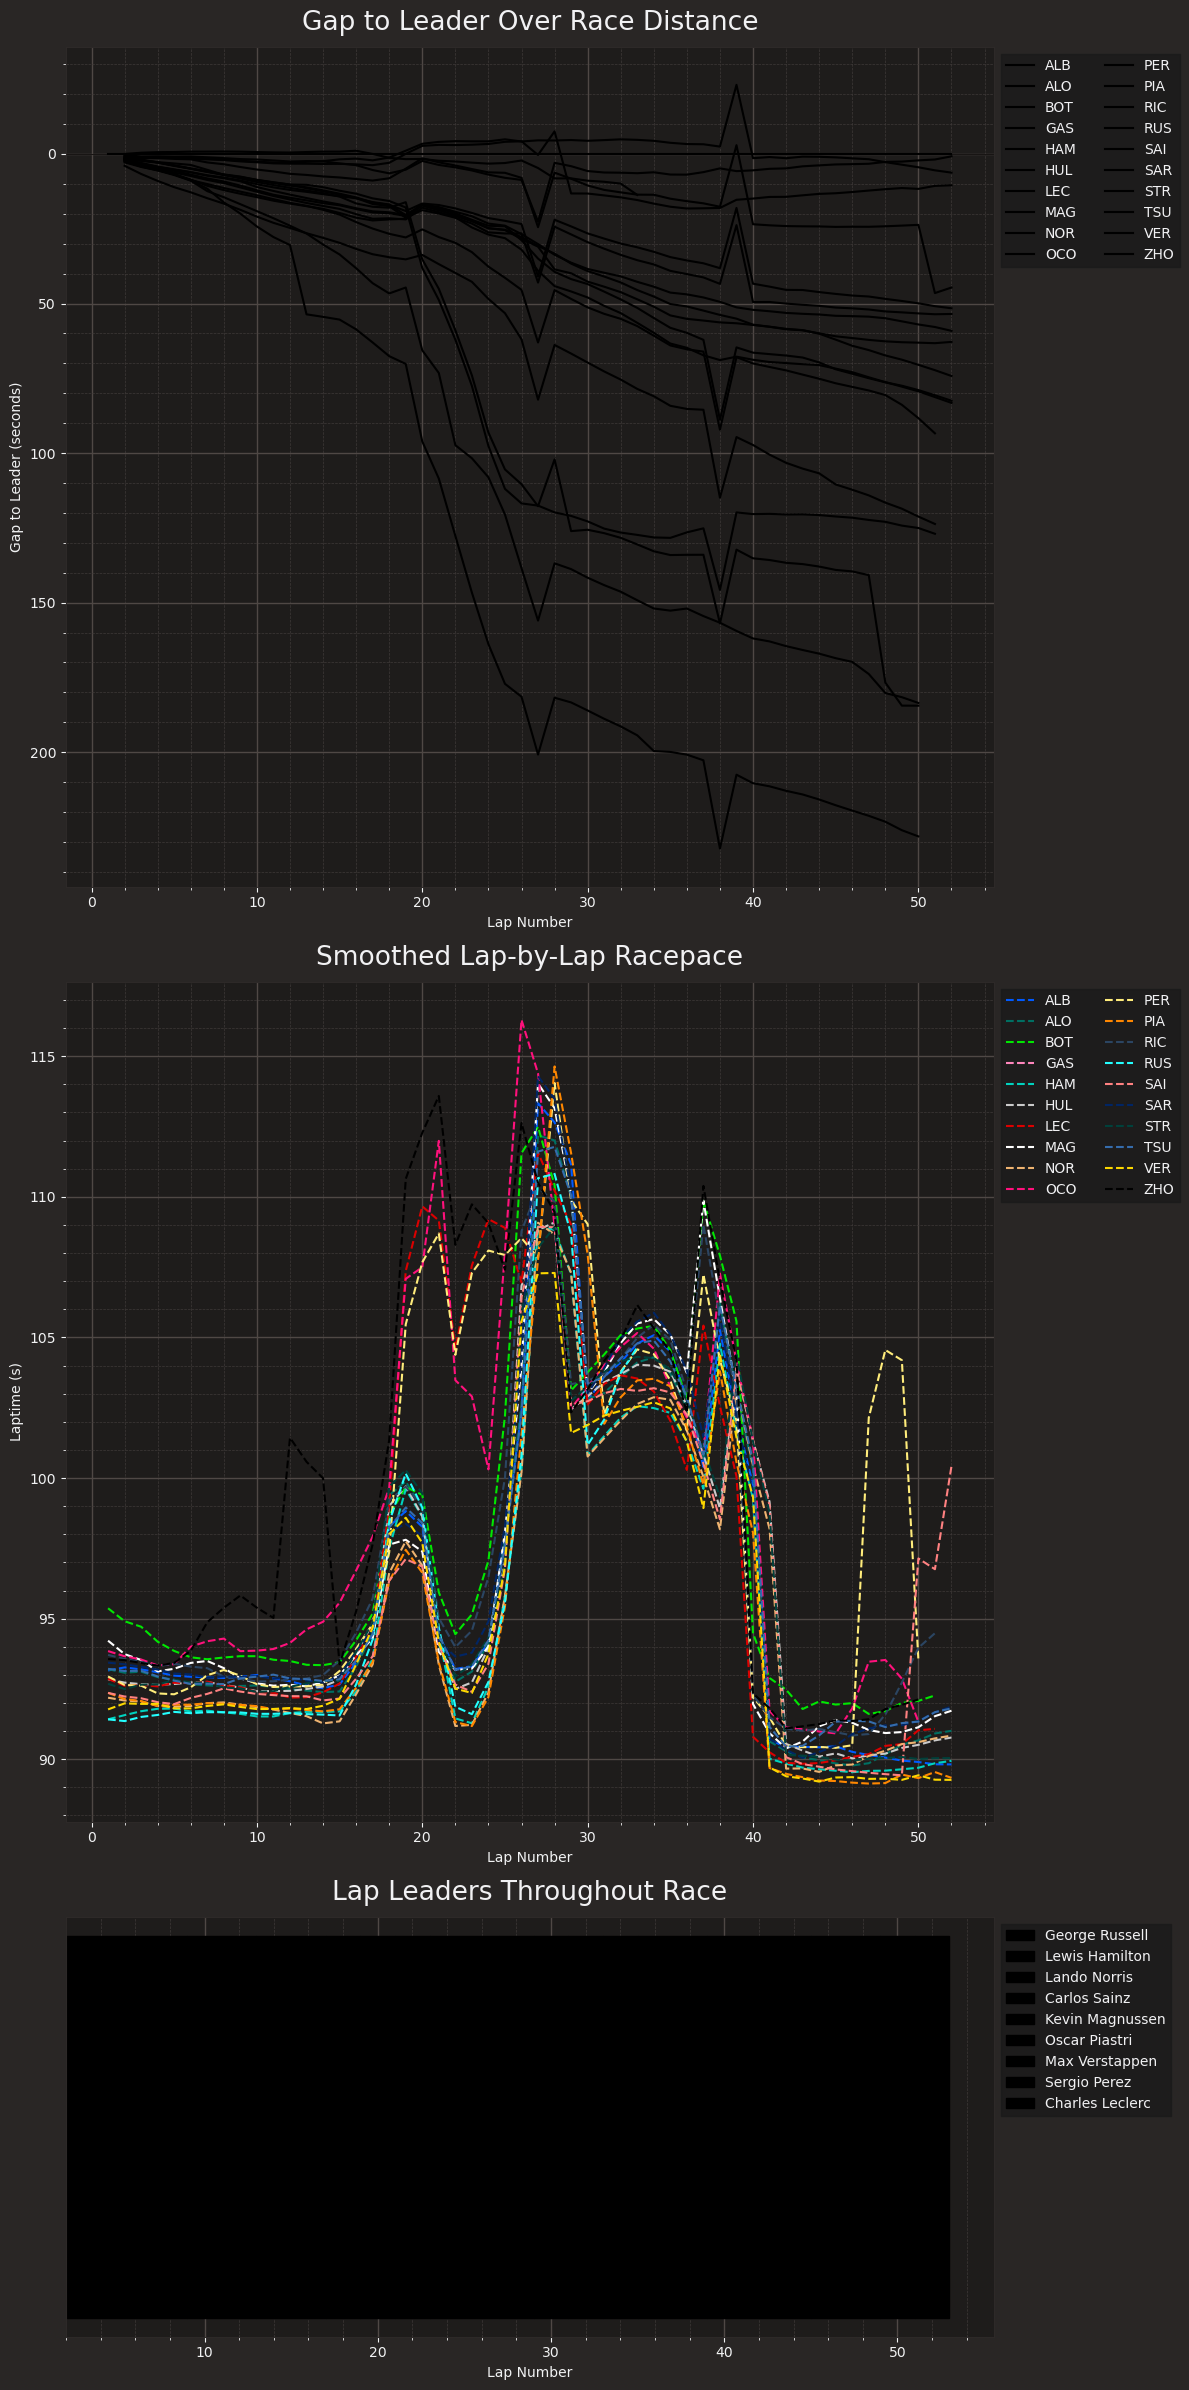

In [66]:
import fastf1 as ff1
from fastf1 import plotting
import matplotlib.pyplot as plt
import pandas as pd

# Set plotting theme
plotting.setup_mpl()

# Load session (Example: 2024 British GP Race)
session = ff1.get_session(2024, 'British', 'R')
session.load()

# Create a mapping of driver abbreviations to full names
drivers_info = {abbr: session.get_driver(abbr)['FullName'] for abbr in session.results['Abbreviation']}

# Get laps data for all drivers
laps = session.laps

# Find the leader's lap times and calculate cumulative race time
leader_abbr = session.results.iloc[0]['Abbreviation']
leader_laps = laps.pick_driver(leader_abbr).copy()
leader_laps['CumulativeTime'] = leader_laps['LapTime'].cumsum()

# Create a list to store each driver's gap to the leader data
gap_list = []
lap_times_list = []

for driver in laps['Driver'].unique():
    driver_laps = laps.pick_driver(driver).copy()
    driver_laps['CumulativeTime'] = driver_laps['LapTime'].cumsum()

    # Append lap times for smoothing plot
    lap_times_list.append(driver_laps[['LapNumber', 'LapTime', 'Driver']])

    if driver == leader_abbr:
        # Leader has zero gap
        driver_laps['GapToLeader'] = 0
        gap_list.append(driver_laps[['LapNumber', 'Driver', 'GapToLeader']])
    else:
        # Merge with leader's cumulative times based on LapNumber
        merged_laps = pd.merge(driver_laps, leader_laps[['LapNumber', 'CumulativeTime']], on='LapNumber', how='left', suffixes=('', '_Leader'))

        # Calculate gap to leader
        merged_laps['GapToLeader'] = (merged_laps['CumulativeTime'] - merged_laps['CumulativeTime_Leader']).dt.total_seconds()

        # Append driver's gap data
        gap_list.append(merged_laps[['LapNumber', 'Driver', 'GapToLeader']])

# Concatenate the list of DataFrames into single DataFrames
gap_df = pd.concat(gap_list).sort_values(by=['LapNumber', 'Driver'])
lap_times_df = pd.concat(lap_times_list).sort_values(by=['LapNumber', 'Driver'])

# Determine lap leaders
laps['Leader'] = laps.groupby('LapNumber')['LapTime'].transform('min') == laps['LapTime']
leaders = laps[laps['Leader']].sort_values(by='LapNumber')
leaders = leaders[['LapNumber', 'Driver']].reset_index(drop=True)

# Group consecutive laps by leader
leaders['Change'] = (leaders['Driver'] != leaders['Driver'].shift()).cumsum()
leaders_grouped = leaders.groupby(['Change', 'Driver']).agg({'LapNumber': ['min', 'max']}).reset_index()
leaders_grouped.columns = ['Change', 'Driver', 'LapStart', 'LapEnd']

# Plot configuration
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 24), gridspec_kw={'height_ratios': [2, 2, 1]})

# DRIVER_COLORS
driver_colors = plotting.DRIVER_COLORS

# Plot gap to leader chart
for driver in gap_df['Driver'].unique():
    driver_full_name = drivers_info.get(driver, 'unknown').lower().replace(' ', '')
    color = driver_colors.get(driver_full_name, '#000000')  # Fallback to black if driver not found
    driver_gap = gap_df[gap_df['Driver'] == driver]
    ax1.plot(driver_gap['LapNumber'], driver_gap['GapToLeader'], label=driver, color=color)

ax1.set_xlabel('Lap Number')
ax1.set_ylabel('Gap to Leader (seconds)')
ax1.set_title('Gap to Leader Over Race Distance')
ax1.axhline(y=0, color='black', linewidth=0.5)  # Add horizontal line at y=0
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)  # Place legend outside the plot
ax1.grid(True)
ax1.invert_yaxis()  # Invert y-axis to have the leader on top

# Plot smoothed lap-by-lap race pace
for driver in lap_times_df['Driver'].unique():
    driver_full_name = drivers_info.get(driver, 'unknown').lower()
    color = driver_colors.get(driver_full_name, '#000000')  # Fallback to black if driver not found
    driver_lap_times = lap_times_df[lap_times_df['Driver'] == driver]

    # Convert LapTime to total seconds for smoothing
    lap_times_seconds = driver_lap_times['LapTime'].dt.total_seconds()

    # Smooth lap times (rolling average)
    smoothed_times = lap_times_seconds.rolling(window=3, min_periods=1, center=True).mean()

    ax2.plot(driver_lap_times['LapNumber'], smoothed_times, label=driver, color=color, linestyle='--')

ax2.set_xlabel('Lap Number')
ax2.set_ylabel('Laptime (s)')
ax2.set_title('Smoothed Lap-by-Lap Racepace')
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)  # Place legend outside the plot
ax2.grid(True)

# Plot lap leaders as a horizontal bar chart
for idx, row in leaders_grouped.iterrows():
    driver_abbr = row['Driver']
    driver_full_name = drivers_info.get(driver_abbr, 'unknown').lower().replace(' ', '')  # Convert name to lowercase to match dictionary keys
    color = driver_colors.get(driver_full_name, '#000000')  # Fallback to black if driver not found
    ax3.barh(0, row['LapEnd'] - row['LapStart'] + 1, left=row['LapStart'], color=color, edgecolor='black')

# Add the legend for the horizontal bar chart
handles = [plt.Rectangle((0, 0), 1, 1, color=driver_colors.get(drivers_info.get(driver_abbr, 'unknown').lower().replace(' ', ''), '#000000'))
           for driver_abbr in leaders_grouped['Driver'].unique()]
labels = [drivers_info.get(driver_abbr, 'Unknown') for driver_abbr in leaders_grouped['Driver'].unique()]
ax3.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

ax3.set_xlabel('Lap Number')
ax3.set_title('Lap Leaders Throughout Race')
ax3.set_yticks([])   # Remove y-axis to emphasize single line
ax3.grid(True)

plt.tight_layout()
plt.show()